# Floating point, Julia, and why computers are bad at math

## Purpose

The purpose of this notebook is to cover the quirks of floating point arithmetic, how computers do math, and things to look out for when implementing algorithms.

## Takeaways

- Real numbers are not real
- Computers make mistakes when they do math
- The code you write isn't the code that gets executed
- Algorithms are not just O(operation), they are also O(memory)
- There are different types of memory!
- CPUs learn!

In [ ]:
using LinearAlgebra
using Plots
using Random
using Test
Random.seed!(1234);

## Section 1: Julia

In [ ]:
1 + 1

In [ ]:
println("Hello, World!, said the 🐱π.")

In [ ]:
x = [1, 2, 3]

In [ ]:
A = [1 2; 3 4]

In [ ]:
eigvals(A)

### Why is Julia fast?

In [ ]:
f(x) = 2x + 1

In [ ]:
@code_warntype f(1)

In [ ]:
@code_warntype f(1.0im + 1)

In [ ]:
using Zygote  # A package for automatic differentiation

f'(3)

In [ ]:
@code_native f'(6)

## What's an integer

In [ ]:
bitstring(Int8(1))

In [ ]:
length(bitstring(Int8(1)))

In [ ]:
bitstring(123456)

In [ ]:
"""
    string_to_int(s::String; is_big_endian::Bool = true)

Return the integer corresponding to a string `s` 
representing the bits of an integer.

If `is_big_endian`, assumes bits are stored from most-signifcant
bit to least. If `!is_big_endian`, assumes bits are stored in 
little-Endian, i.e., least-significant bit to most.
"""
function string_to_int(s::String; is_big_endian::Bool = true)
    y = 0
    for (i, x) in enumerate(is_big_endian ? reverse(s) : s)
        if x == '1'
            y += 2^(i-1)
        end
    end
    return y
end

@testset "big_endian" begin 
    for i = 0:1024
        @test string_to_int(bitstring(i)) == i
    end
end

@testset "little_endian" begin 
    @test string_to_int(bitstring(0); is_big_endian = false) == 0
    for i = 1:1024
        @test string_to_int(bitstring(i); is_big_endian = false) != i
    end
end

## What do floats float on anyway

In [ ]:
0.1 + 0.2 ≈ 0.3

In [ ]:
√eps(Float64)

In [ ]:
?isapprox

In [ ]:
my_float = 0.1

In [ ]:
bitstring(my_float)

Floats have three components:

$$sign * significand * 2^{exponent}$$

In [ ]:
Base.sign(my_float)

In [ ]:
Base.significand(my_float)

In [ ]:
Base.exponent(my_float)

In [ ]:
1.0 * (1.6) * (2)^(-4)

In [ ]:
BigFloat(0.1)

Floats are stored as a string of bits. A `Float64` has 64 bits:

In [ ]:
my_float_bits = bitstring(my_float)

The first bit is the sign bit:

In [ ]:
s_my_sign = my_float_bits[1]

Sign bits are stored:
$$-1^{bit}$$

In [ ]:
my_sign = (-1) ^ parse(Int, s_my_sign)

Bits 2 through 12 (i.e., 11 bits) are the exponent:

In [ ]:
s_my_exponent = my_float_bits[2:12]

Exponents are stored with a bias, which depends on the number bits in the floating point number. For `Float64`, the bias is 1023.

In [ ]:
my_exponent = string_to_int(s_my_exponent) - 1023

The remaining bits (13--64) (i.e., 52 bits) encode the significand.

In [ ]:
s_my_significand = my_float_bits[13:end]

Given a bitstring `s`, the significand is stored as follows: 
$$significand = 1 + \sum_i s_i \times 2^{-i}. $$

In [ ]:
1//2

In [ ]:
"""
    string_to_inv_rational(s::String)

Return Σᵢ sᵢ * 2⁻ⁱ. 

Note that bits are still stored from most-significant to least
(big Endian), but because the coefficient is decreasing, we walk
fowards through the string.
"""
function string_to_inv_rational(s::String)
    y = 0 // 1
    for (i, x) in enumerate(s)
        if x == '1'
            y += 1 // 2^i
        end
    end
    return y
end

@test string_to_inv_rational("000") == 0 // 8
@test string_to_inv_rational("001") == 1 // 8
@test string_to_inv_rational("010") == 2 // 8
@test string_to_inv_rational("011") == 3 // 8
@test string_to_inv_rational("100") == 4 // 8
@test string_to_inv_rational("101") == 5 // 8
@test string_to_inv_rational("110") == 6 // 8
@test string_to_inv_rational("111") == 7 // 8

In [ ]:
my_significand = 1 + string_to_inv_rational(s_my_significand)

In [ ]:
BigFloat(my_significand)

Putting this all together gives:

In [ ]:
my_sign * my_significand * 2.0^my_exponent

In [ ]:
BigFloat(my_sign * my_significand * 2.0^my_exponent)

Here's another explanation: https://www.exploringbinary.com/why-0-point-1-does-not-exist-in-floating-point/

Because of the way they are stored, floats cannot represent all real numbers. Instead, they approximate the real numbers by a finite set of values, they spacing between which depends on where the value is in the number line.

In [ ]:
typemin(Float64)

In [ ]:
nextfloat(typemin(Float64))

In [ ]:
x = nextfloat(typemin(Float64))
nextfloat(x) - x

In [ ]:
nextfloat(x)

In [ ]:
x = Float64(0.0)
nextfloat(x) - x

In [ ]:
x = typemin(Float16)
y = Float64[x]
while x < typemax(Float16)
    x = nextfloat(x)
    push!(y, x)
end
y

In [ ]:
plot(
    y[2:end], diff(y),
    title = "Float16",
    xlabel = "Float16(x)",
    ylabel = "Gap between two nearest values",
    legend = false,
    w = 2,
    size = (600, 300)
)

In [ ]:
plot(
    y[2:end], abs.(diff(y) ./ y[2:end]),
    title = "Float16",
    xlabel = "Float16(x)",
    ylabel = "Relative gap between two nearest values",
    legend = false,
    w = 2,
    ylims=(0, 0.001),
    size = (600, 300)
)

For `Float64`, the relative gap is on the order of 1e-16.

In [ ]:
rel_float(x) = log10(big(nextfloat(Float64(x))) / Float64(x))
@show rel_float(1.0)
@show rel_float(1e6)
@show rel_float(1e100)

What happens if the result of a computation falls in one of the "missing" intervals of the real line?

In [ ]:
bitstring(Float16(0.1, RoundNearest))

In [ ]:
bitstring(Float16(0.1, RoundDown))

In [ ]:
bitstring(Float16(0.1, RoundUp))

## Takeaways

- Floating point arithmetic has **relative** accuracy.

## Benchmarking

In [ ]:
using BenchmarkTools

const sum_x = rand(2^16)

In [ ]:
sum_1(x::Vector{T}) where {T} = sum(x)
@btime sum_1($sum_x)

In [ ]:
function sum_2(x::Vector{T}) where {T}
    y = zero(T)
    for i = 1:length(x)
        y += x[i]
    end
    return y
end
@btime sum_2($sum_x)

In [ ]:
function sum_3(x::Vector{T}) where {T}
    @assert mod(length(x), 4) == 0
    y = zero(T)
    i = 1
    while i < length(x)
        y += x[i] + x[i + 1] + x[i + 2] + x[i + 3]
        i += 4
    end
    return y
end
@btime sum_3($sum_x)

In [ ]:
function sum_4(x::Vector{T}) where {T}
    @assert mod(length(x), 4) == 0
    y = zero(T)
    i = 1
    @inbounds while i < length(x)
        y += x[i] + x[i + 1] + x[i + 2] + x[i + 3]
        i += 4
    end
    return y
end
@btime sum_4($sum_x)

## Has anyone noticed something weird about the sum totals?

In [ ]:
@show sum_1(sum_x) - sum_2(sum_x)
@show sum_1(sum_x) - sum_3(sum_x)
@show sum_1(sum_x) - sum_4(sum_x)

## What's going on?

In [ ]:
1 + 1e-16 == 1

In [ ]:
run(`python -c 'print(1.0 + 1e-16 == 1.0)'`)

Floating point numbers are bad at doing math when they are far apart from each other!

## One solution: Kahan summation

https://en.wikipedia.org/wiki/Kahan_summation_algorithm

In [ ]:
function KahanSum(x)
    y = 0.0
    c = 0.0
    for i = 1:length(x)
        z = x[i] - c
        t = y + z
        c = (t - y) - z
        y = t
    end
    return y
end

sum(sum_x) - KahanSum(sum_x)

### Explanation

- In each iteration: 
  - `y` is big compared to `x`
  - `x` is similar to `c`
  - `y` is similar to `t`
- If `t > y + z`, then we have "overshot" the sum. 
  - ⟹`(t - y) - z > 0`
  - ⟹ we subtract a positive `c` on the next iteration correct for the over-shoot
- If `t < y + z`, then we have "undershot" the sum.
  - ⟹`(t - y) - z < 0`
  - ⟹ we subtract a negative `c` on the next iteration correct for the over-shoot



## Another solution: Arbitrary precision arithmetic

In [ ]:
big(0.1)

In [ ]:
precision(big(0.1))

In [ ]:
sum(big.(sum_x)) - sum_2(big.(sum_x))

In [ ]:
@btime sum(big.(sum_x))
@btime sum(sum_x)

In [ ]:
f(k::T) where {T} = abs.(k * T(0.1) - sum(T(0.1) for i = 1:k))
x32 = Float32(10).^(1:8)
x64 = Float64(10).^(1:8)
plot(
    xlabel = "log10(k)",
    ylabel = "log10(f(k))",
    xscale = :log10, 
    yscale = :log10,
    legend = :bottomright
)
plot!(x64, f.(x32), label = "Float32", w = 3)
plot!(x64, f.(x64), label = "Float64", w = 3)

# Take-aways

- Real numbers aren't real
- Computers are good at math when numbers are similar orders of magnitude
- `Float64` can compare across ~16 orders of magnitude
- It's easy to lose a few bits of precision when doing calculations
    - Let's say 4 for safety
- If you have a tolerance of 10e-6, don't use numbers larger than 10e+6!

## Performance: Part II

In [ ]:
function sum_matrix_col_row(X)
    I, J = size(X)
    y = 0.0
    for i = 1:I
        for j = 1:J
            y += X[i, j]
        end
    end
    return y
end

function sum_matrix_row_col(X)
    I, J = size(X)
    y = 0.0
    for j = 1:J
        for i = 1:I
            y += X[i, j]
        end
    end
    return y
end

In [ ]:
N = 10_000
X = rand(N, N)
@btime sum_matrix_col_row($X)
@btime sum_matrix_row_col($X)

## What's happening here?

- Computers don't just have RAM
- They have _caches_ as well
  - Caches are closer to the CPU, but have much less capacity
  - L1 ~ 32 KB ~ 4096 Float64s
  - L2 ~ 256 KB ~ 32,768 Float64s
  - L3 ~ 4 MB ~ 524,288 Float64s
- When we ask for `x[i]`, the computer expects that we will probably want to access `x[i+1]`, `x[i+2]`, ..., so it fetches a block of memory _once_, rather than one-by-one.
- Julia stores matrices in column-major order (i.e., column by column), so the CPU will pull in the next values in the list!
- If we iterate row-by-row, then the next value isn't in the cache, and we have to perform a new memory fetch.

## Want to see something crazy?

Computers can learn! Not Julia, but the actual CPU.

In the following benchmark, we look at a simple challenging of returning all the indices for which an element in an array is `true`:

In [ ]:
x = rand(Bool, 5)

In [ ]:
findall(x)

Specifically, we're going to time how fast the computer is if the array has a periodical structure, so
`[true, false, true, false, ...]` or `[true true false, true, true, false, ...]`.

As we will see, my macbook can learn really long periods!

In [ ]:
using Printf, BenchmarkTools

const CPU_SPEED_GHZ = Sys.cpu_info()[1].speed / 1_000
const CPU_MODEL = Sys.cpu_info()[1].model;

function print_line(n, time, reference_time, cycle_time, penalty)
    @printf(
        "Period %5d: %7.2f us = %7.2f cycles per idx. Relative time %6.2f%%\n", 
        n, 
        time * 10^6, 
        time * cycle_time, 
        time / reference_time * 100
#         100 * (time - reference_time) * cycle_time / penalty 
    )
end

begin 
    # Calibrate performance with 30,000 values.
    N = 30_000
    # list = [true, false, true, false, ..., true, false]
    list = fill(false, N)
    list[1:2:end] .= true 
    true_false_time = @belapsed findall($list)
    # Now make list totally random
    list .= rand(Bool, N)
    random_time = @belapsed findall($list)
    # Adjustment to convert time to CPU cycles
    time_to_cycle = 10^9 / N * CPU_SPEED_GHZ
    # Compute how many cycles it takes if we mis-predict a branch
    penalty = 2 * (random_time - true_false_time) * time_to_cycle
    @printf(
        "\n\n%s; branch-miss penalty: %4.1f ns = %4.1f cycles\n\n", 
        CPU_MODEL, penalty / CPU_SPEED_GHZ, penalty
    )

    print_line(30_000, random_time, random_time, time_to_cycle, penalty)
    for n in [10_000, 5_000, 3_000, 2_500, 1_000, 500, 100, 2]
        # Generate a random Boolean pattern of length n, so now 
        #     list = [pattern, pattern, ..., pattern]
        pattern = rand(Bool, n)
        for i = 1:n:N 
            list[i:(i + n - 1)].= pattern
        end
        # Time how long to find all `true`s
        time = @belapsed findall($list)

        print_line(n, time, random_time, time_to_cycle, penalty)
    end
end

In [ ]:
using Statistics
function run_experiment(N, n, K)
    list = fill(false, N)
    pattern = rand(Bool, n)
    for i = 1:n:N
        list[i:(i + n - 1)] .= pattern
    end
    list
    GC.gc()
    times = [@elapsed findall(list) for _ in 1:K]
    plot!(
        times, 
        ylims=(0, 0.0002),
        legend = false
    )
end


plot()
for i = 1:30
    run_experiment(30000, 100, 50)
end
plot!(xlabel = "Repetition", ylabel = "Execution time")

# Takeaways

- Real numbers are not real
- Computers make mistakes when they do math
- The code you write isn't the code that gets executed
- Algorithms are not just O(operation), they are also O(memory)
- There are different types of memory!
- CPUs learn!

## Addenda: cosmic rays

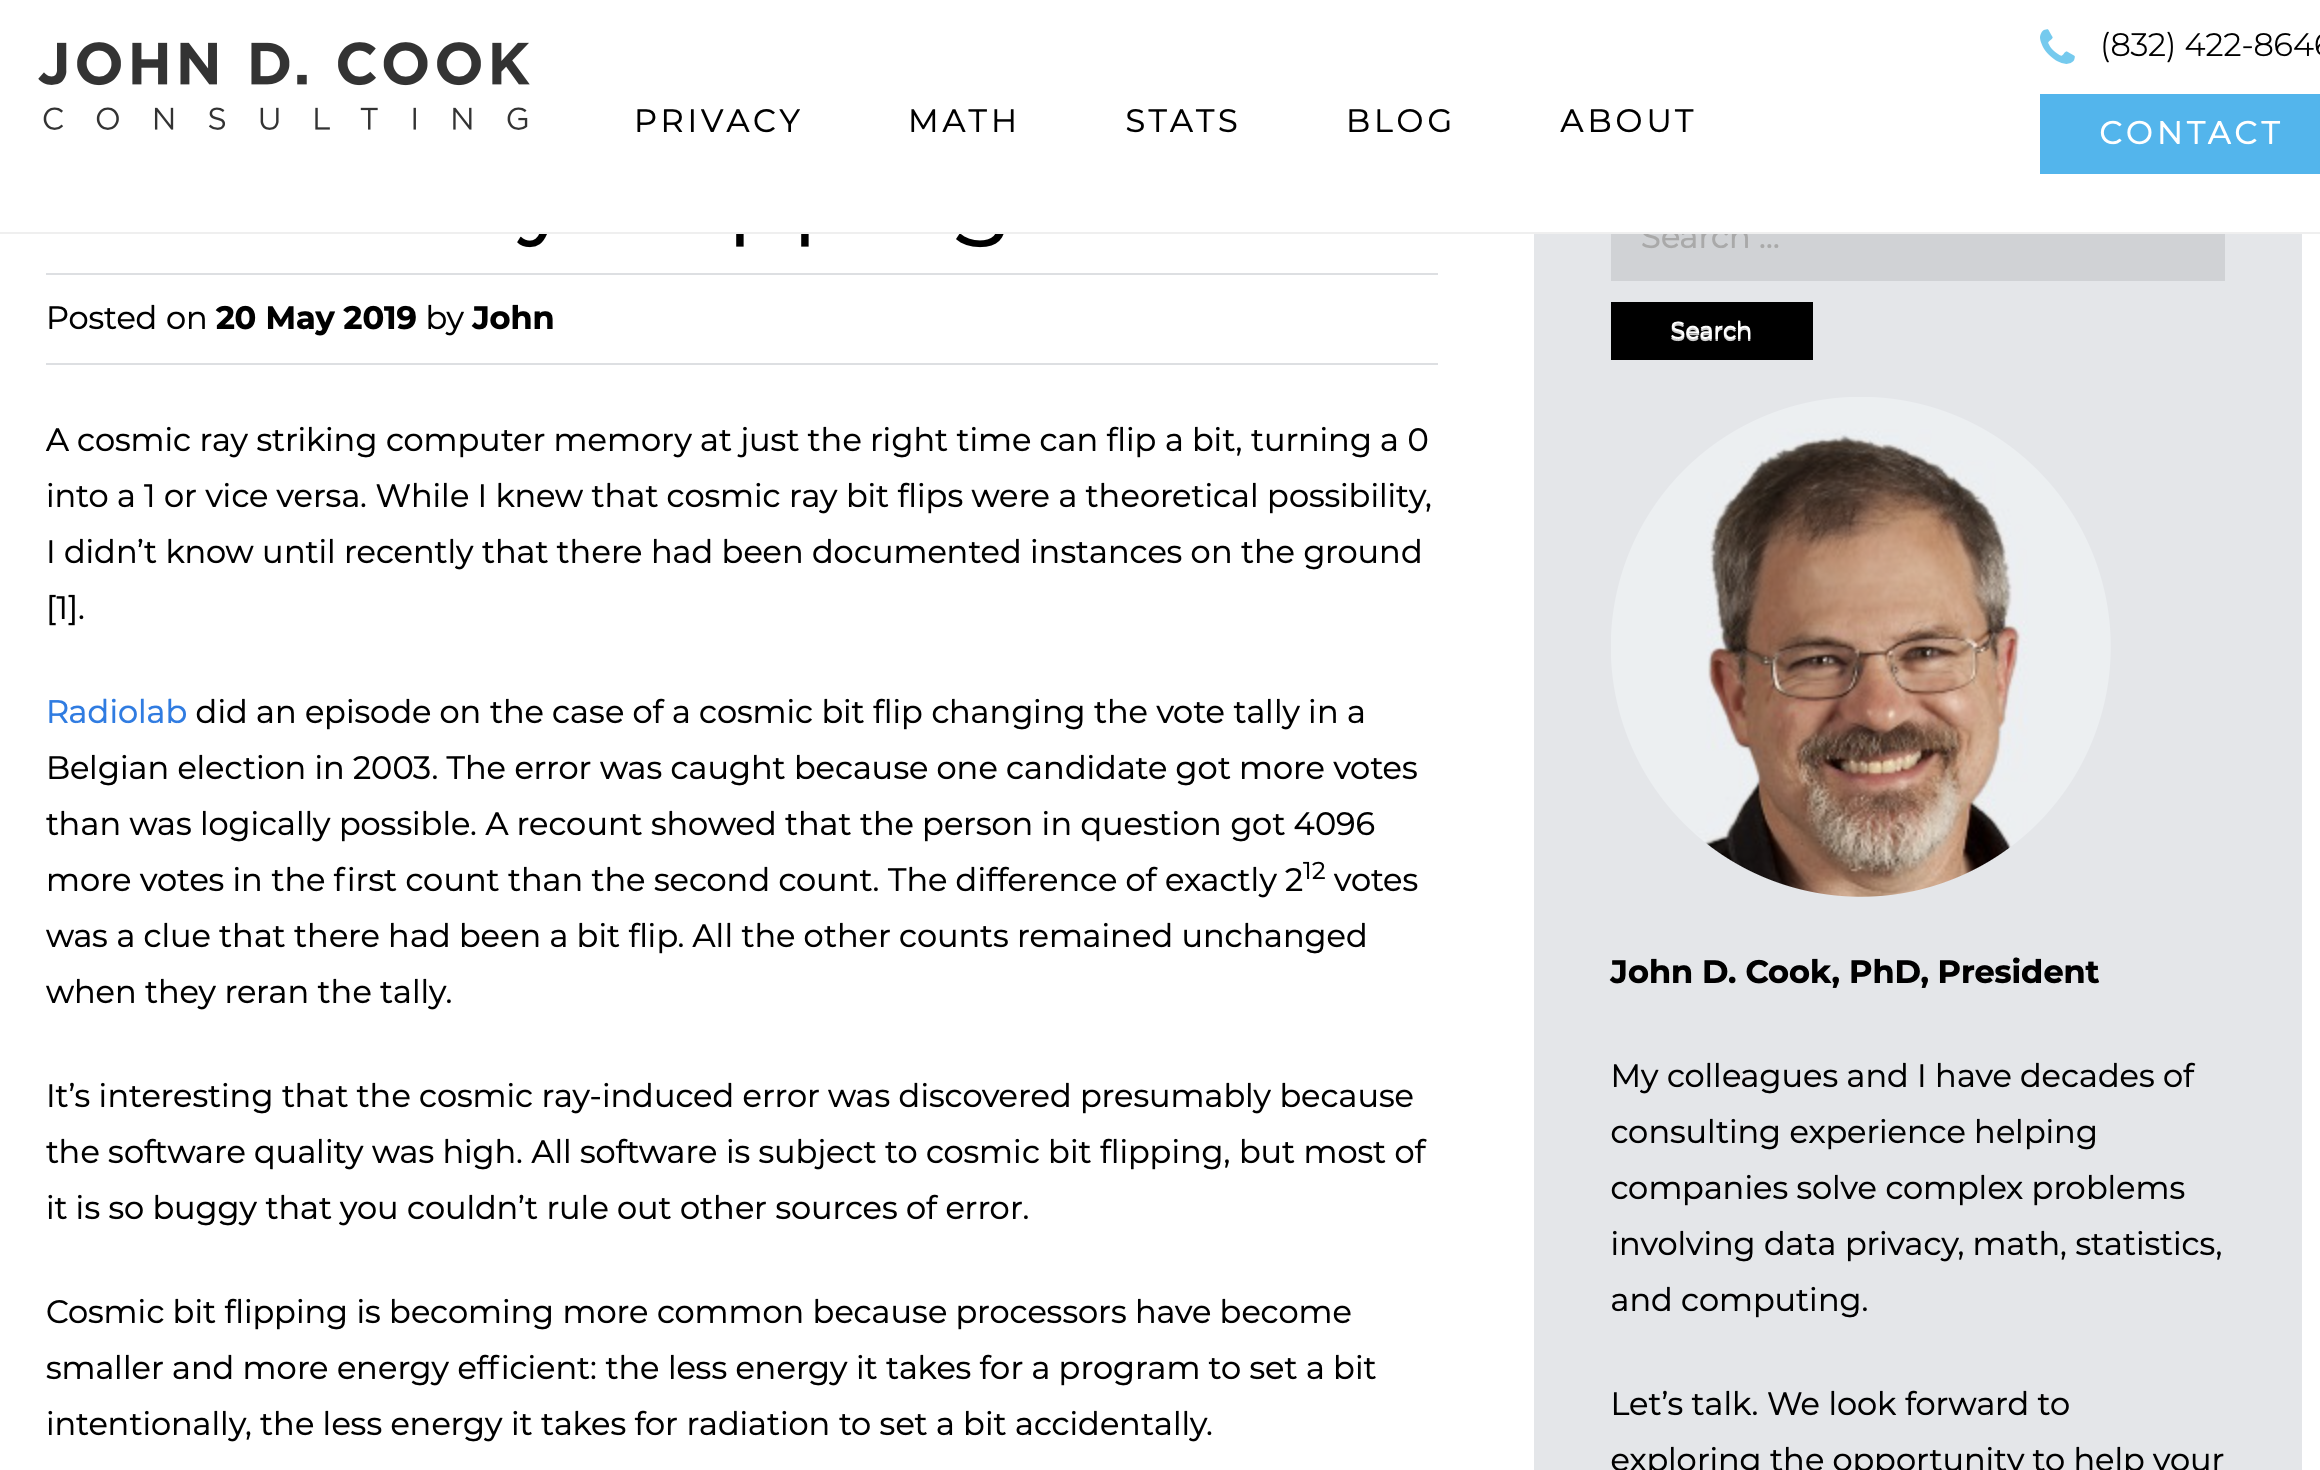

https://www.johndcook.com/blog/2019/05/20/cosmic-rays-flipping-bits/